In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

print(f"Tensorflow version : {tf.__version__}")
import warnings
warnings.filterwarnings('ignore')

2025-01-27 17:07:01.927878: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-27 17:07:02.027567: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737997622.079509   16593 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737997622.095370   16593 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-27 17:07:02.164052: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Tensorflow version : 2.18.0


In [2]:
data = pd.read_csv("https://raw.githubusercontent.com/laxmimerit/All-CSV-ML-Data-Files-Download/refs/heads/master/twitter_multi_class_sentiment.csv")

In [3]:
data.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


In [4]:
print(data.shape)

(16000, 3)


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        16000 non-null  object
 1   label       16000 non-null  int64 
 2   label_name  16000 non-null  object
dtypes: int64(1), object(2)
memory usage: 375.1+ KB


# Data Analysis

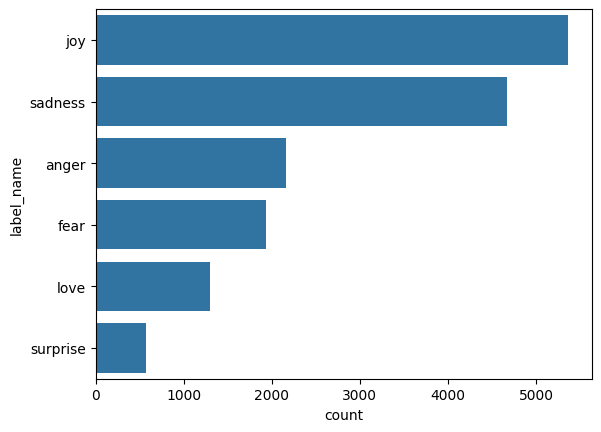

In [6]:
order = data['label_name'].value_counts().index
sns.countplot(data=data,y='label_name',order=order);

In [7]:
data['words_per_tweet'] = data['text'].str.split().apply(len)

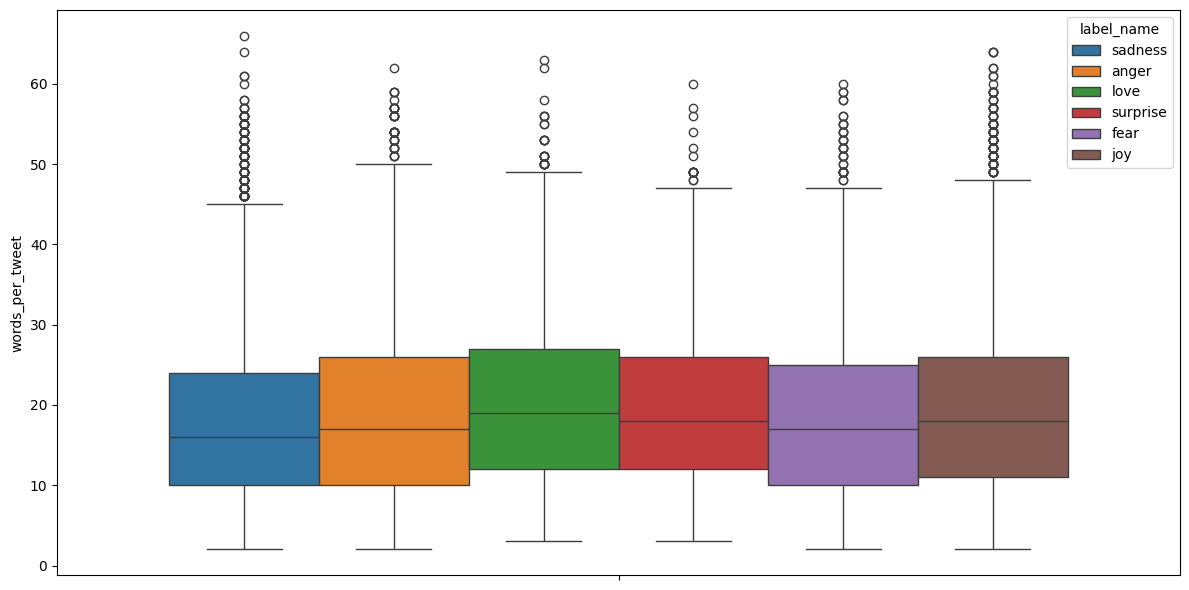

In [8]:
plt.figure(figsize=(12,6))  # Adjust figure size
sns.boxplot(data=data, y='words_per_tweet', hue='label_name')
plt.tight_layout() 
plt.show()

# Text to token Conversion

In [9]:
from transformers import AutoTokenizer

In [10]:
model_ckpt = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [11]:
text = "I love machine learning , Tokenization is awesome!!"
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 1045, 2293, 3698, 4083, 1010, 19204, 3989, 2003, 12476, 999, 999, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


# Data Loader & Train - Test Split

In [12]:
from sklearn.model_selection import train_test_split

train,test = train_test_split(data,test_size=0.3,random_state=42,stratify=data['label_name'])
test,validation = train_test_split(test,test_size=1/3,random_state=42,stratify=test['label_name'])
print(f"Training data shape : {train.shape}")
print(f"Testing data shape : {test.shape}")
print(f"Validation data shape : {validation.shape}")

Training data shape : (11200, 4)
Testing data shape : (3200, 4)
Validation data shape : (1600, 4)


In [13]:
from datasets import Dataset,DatasetDict

dataset = DatasetDict(
    {
        'train':Dataset.from_pandas(train,preserve_index=False),
        'test':Dataset.from_pandas(test,preserve_index=False),
        'validation':Dataset.from_pandas(validation,preserve_index=False)
    }
)

In [14]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_name', 'words_per_tweet'],
        num_rows: 11200
    })
    test: Dataset({
        features: ['text', 'label', 'label_name', 'words_per_tweet'],
        num_rows: 3200
    })
    validation: Dataset({
        features: ['text', 'label', 'label_name', 'words_per_tweet'],
        num_rows: 1600
    })
})

# Tokenization of the emotion/sentiment data

In [15]:
def tokenize(batch):
    temp = tokenizer(batch['text'],padding=True,truncation=True)
    return temp

In [16]:
emotion_encoded = dataset.map(tokenize,batched=True,batch_size=None)

Map:   0%|          | 0/11200 [00:00<?, ? examples/s]

Map:   0%|          | 0/3200 [00:00<?, ? examples/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

In [17]:
emotion_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_name', 'words_per_tweet', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 11200
    })
    test: Dataset({
        features: ['text', 'label', 'label_name', 'words_per_tweet', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3200
    })
    validation: Dataset({
        features: ['text', 'label', 'label_name', 'words_per_tweet', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1600
    })
})

In [18]:
label2id = {x['label_name']:x['label'] for x in dataset['train']}
id2label = {x['label']:x['label_name'] for x in dataset['train']}
print(label2id)
print(id2label)

{'sadness': 0, 'joy': 1, 'fear': 4, 'surprise': 5, 'anger': 3, 'love': 2}
{0: 'sadness', 1: 'joy', 4: 'fear', 5: 'surprise', 3: 'anger', 2: 'love'}


# Model Building

In [19]:
from transformers import AutoModel
import torch

In [20]:
model = AutoModel.from_pretrained(model_ckpt)

In [21]:
model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [22]:
model.config

BertConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.48.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [23]:
from transformers import AutoModelForSequenceClassification,AutoConfig

In [24]:
num_labels = len(label2id)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [25]:
config = AutoConfig.from_pretrained(model_ckpt,label2id=label2id,id2label=id2label)

In [26]:
config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "sadness",
    "1": "joy",
    "2": "love",
    "3": "anger",
    "4": "fear",
    "5": "surprise"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "anger": 3,
    "fear": 4,
    "joy": 1,
    "love": 2,
    "sadness": 0,
    "surprise": 5
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.48.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [27]:
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt,config=config).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [29]:
import evaluate

In [30]:
from transformers import TrainingArguments

batch_size = 64
training_dir = 'bert_base_train_dir'

training_args = TrainingArguments(
    output_dir=training_dir,
    overwrite_output_dir=True,
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_gpu_eval_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy='epoch',
    disable_tqdm=False
)

In [31]:
# Build compute metrics function
# !pip install evaluate
import evaluate
import numpy as np

accuracy = evaluate.load("accuracy")

def compute_metrics_evaluate(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)


In [32]:
# use sklearn to build compute metrics
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)

    return {"accuracy": acc, "f1": f1}


# Build Model & Trainer

In [33]:
from transformers import Trainer

In [34]:
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=emotion_encoded['train'],
    eval_dataset=emotion_encoded['validation'],
    tokenizer = tokenizer
)

In [35]:
trainer

In [36]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.498109,0.846875,0.833613
2,No log,0.277198,0.917500,0.916865


Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.


TrainOutput(global_step=350, training_loss=0.7371407645089286, metrics={'train_runtime': 1424.6639, 'train_samples_per_second': 15.723, 'train_steps_per_second': 0.246, 'total_flos': 1001502421516800.0, 'train_loss': 0.7371407645089286, 'epoch': 2.0})

# Model Evaluation

In [37]:
preds_output = trainer.predict(emotion_encoded['test'])
preds_output.metrics

Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.


Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.


{'test_loss': 0.3214031159877777,
 'test_accuracy': 0.9021875,
 'test_f1': 0.9011766700126154,
 'test_runtime': 11.8647,
 'test_samples_per_second': 269.708,
 'test_steps_per_second': 4.214}

In [38]:
y_pred = np.argmax(preds_output.predictions, axis=1)
y_true = emotion_encoded['test'][:]['label']

In [39]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       933
           1       0.92      0.92      0.92      1072
           2       0.82      0.72      0.77       261
           3       0.90      0.91      0.90       432
           4       0.87      0.89      0.88       387
           5       0.82      0.73      0.77       115

    accuracy                           0.90      3200
   macro avg       0.87      0.85      0.86      3200
weighted avg       0.90      0.90      0.90      3200



In [40]:
# plot confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

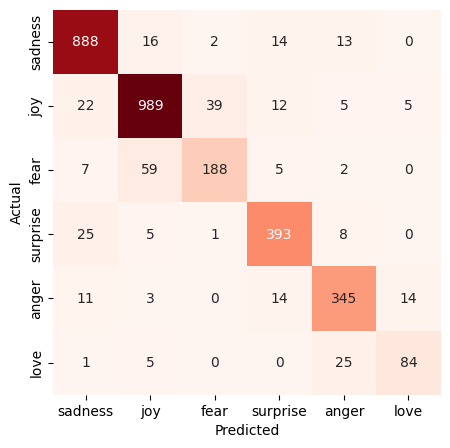

In [41]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, xticklabels=label2id.keys(), yticklabels=label2id.keys(), fmt='d', cbar=False, cmap='Reds')
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

In [42]:
text = "I am super happy today. I got it done. Finally!!"

def get_prediction(text):
    input_encoded = tokenizer(text, return_tensors='pt').to(device)

    with torch.no_grad():
        outputs = model(**input_encoded)

    logits = outputs.logits

    pred = torch.argmax(logits, dim=1).item()
    return id2label[pred]

get_prediction(text)

'joy'

In [43]:
trainer.save_model("bert-base-uncased-sentiment-model")

In [44]:
# use pipeline for prediciton
from transformers import pipeline

classifier = pipeline('text-classification', model= 'bert-base-uncased-sentiment-model')

classifier([text, 'hello, how are you?', "love you", "i am feeling low"])

Device set to use cuda:0


[{'label': 'joy', 'score': 0.9597744345664978},
 {'label': 'joy', 'score': 0.8496931791305542},
 {'label': 'love', 'score': 0.4380156993865967},
 {'label': 'sadness', 'score': 0.9605658650398254}]